Deep Learning
=============

Assignment 2
------------

Previously in `1_notmnist.ipynb`, we created a pickle with formatted datasets for training, development and testing on the [notMNIST dataset](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
np.shape(train_dataset.reshape((-1, 28*28)))

(200000, 784)

In [5]:
np.unique(train_labels)

array([ 0.,  1.], dtype=float32)

We're first going to train a multinomial logistic regression using simple gradient descent.

TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

      with graph.as_default():
          ...

* Then you can run the operations on this graph as many times as you want by calling `session.run()`, providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

      with tf.Session(graph=graph) as session:
          ...

Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [6]:
-

Let's run this computation and iterate:

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

V_accur_list = [] #verification accuracy list
step_list = [] # step number list
cost_list = []

In [8]:
num_steps = 801

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

with tf.Session(graph=graph) as session:
    # This is a one-time operation which ensures the parameters get initialized as
    # we described in the graph: random weights for the matrix, zeros for the
    # biases. 
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if (step % 10 == 0):
            cost_list.append(l)
            step_list.append(step)
            print('Loss at step %d: %f' % (step, l))
            print('Training accuracy: %.1f%%' % accuracy(
            predictions, train_labels[:train_subset, :]))
            # Calling .eval() on valid_prediction is basically like calling run(), but
            # just to get that one numpy array. Note that it recomputes all its graph
            # dependencies.
            valid_accuracy = accuracy(valid_prediction.eval(), valid_labels)
            V_accur_list.append(valid_accuracy)
            print('Validation accuracy: %.1f%%' % valid_accuracy)
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))


Initialized
Loss at step 0: 21.956785
Training accuracy: 6.7%
Validation accuracy: 8.3%
Loss at step 10: 5.737443
Training accuracy: 39.4%
Validation accuracy: 41.4%
Loss at step 20: 4.191097
Training accuracy: 55.2%
Validation accuracy: 55.1%
Loss at step 30: 3.630736
Training accuracy: 60.6%
Validation accuracy: 61.0%
Loss at step 40: 3.312489
Training accuracy: 63.7%
Validation accuracy: 64.6%
Loss at step 50: 3.094980
Training accuracy: 65.8%
Validation accuracy: 66.6%
Loss at step 60: 2.931975
Training accuracy: 67.3%
Validation accuracy: 68.1%
Loss at step 70: 2.802547
Training accuracy: 68.6%
Validation accuracy: 69.1%
Loss at step 80: 2.695223
Training accuracy: 69.3%
Validation accuracy: 70.1%
Loss at step 90: 2.603252
Training accuracy: 70.1%
Validation accuracy: 70.8%
Loss at step 100: 2.522671
Training accuracy: 70.6%
Validation accuracy: 71.0%
Loss at step 110: 2.450953
Training accuracy: 71.1%
Validation accuracy: 71.4%
Loss at step 120: 2.386328
Training accuracy: 71.4%


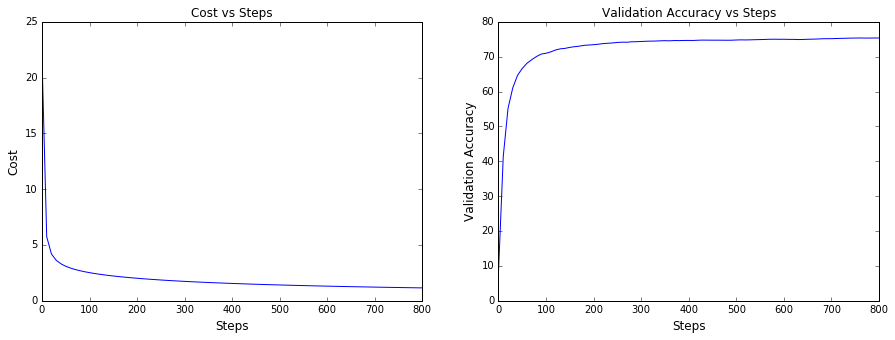

In [9]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5));
axes[0].plot(step_list, cost_list);
axes[0].set_title('Cost vs Steps');
axes[0].set_xlabel('Steps', size = 12);
axes[0].set_ylabel('Cost', size = 12);
axes[1].plot(step_list, V_accur_list);
axes[1].set_title('Validation Accuracy vs Steps');
axes[1].set_xlabel('Steps', size = 12);
axes[1].set_ylabel('Validation Accuracy', size = 12);

Let's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `session.run()`.

In [10]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
  
    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run it:

In [11]:
num_steps = 5001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 16.015167
Minibatch accuracy: 14.1%
Validation accuracy: 16.2%
Minibatch loss at step 500: 2.512875
Minibatch accuracy: 71.1%
Validation accuracy: 74.5%
Minibatch loss at step 1000: 1.371254
Minibatch accuracy: 80.5%
Validation accuracy: 76.3%
Minibatch loss at step 1500: 1.395605
Minibatch accuracy: 73.4%
Validation accuracy: 77.3%
Minibatch loss at step 2000: 1.305051
Minibatch accuracy: 77.3%
Validation accuracy: 76.2%
Minibatch loss at step 2500: 1.168222
Minibatch accuracy: 75.8%
Validation accuracy: 77.8%
Minibatch loss at step 3000: 0.902722
Minibatch accuracy: 78.9%
Validation accuracy: 78.1%
Minibatch loss at step 3500: 0.825330
Minibatch accuracy: 78.9%
Validation accuracy: 78.4%
Minibatch loss at step 4000: 0.987025
Minibatch accuracy: 79.7%
Validation accuracy: 79.5%
Minibatch loss at step 4500: 0.667354
Minibatch accuracy: 82.8%
Validation accuracy: 79.4%
Minibatch loss at step 5000: 0.697824
Minibatch accuracy: 82.8%
Validation accura

---
Problem
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units [nn.relu()](https://www.tensorflow.org/versions/r0.7/api_docs/python/nn.html#relu) and 1024 hidden nodes. This model should improve your validation / test accuracy.

---

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

V_accur_list = [] #verification accuracy list
step_list = [] # step number list
cost_list = []

In [13]:
# Setting up the graph always comes first

batch_size = 128
n_hidden_nodes = 1024
image_size = 28

graph = tf.Graph()
with graph.as_default():
    
    # Input data. For the training data, we use a placeholder that will be 
    # fed at runtime with a training minibatch
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    weights_01 = tf.Variable(
    tf.truncated_normal([image_size * image_size, n_hidden_nodes]))
    weights_12 = tf.Variable(tf.truncated_normal([n_hidden_nodes, num_labels]))
    biases_01 = tf.Variable(tf.zeros([n_hidden_nodes]))
    biases_12 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    z_01= tf.matmul(tf_train_dataset, weights_01) + biases_01
    h1 = tf.nn.relu(z_01)
    z_12 = tf.matmul(h1, weights_12) + biases_12
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(z_12, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(z_12)
    valid_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_01) + biases_01), weights_12) + biases_12)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_01) + biases_01), weights_12) + biases_12) 

In [14]:
num_steps = 6001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 100 == 0):
            cost_list.append(l)
            step_list.append(step)
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            valid_accuracy = accuracy(valid_prediction.eval(), valid_labels)
            V_accur_list.append(valid_accuracy)
            print("Validation accuracy: %.1f%%" % valid_accuracy)
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 370.188629
Minibatch accuracy: 5.5%
Validation accuracy: 36.7%
Minibatch loss at step 100: 43.089180
Minibatch accuracy: 77.3%
Validation accuracy: 75.5%
Minibatch loss at step 200: 23.482714
Minibatch accuracy: 75.8%
Validation accuracy: 78.0%
Minibatch loss at step 300: 35.722511
Minibatch accuracy: 78.9%
Validation accuracy: 77.6%
Minibatch loss at step 400: 17.088871
Minibatch accuracy: 86.7%
Validation accuracy: 78.4%
Minibatch loss at step 500: 11.470387
Minibatch accuracy: 78.1%
Validation accuracy: 80.3%
Minibatch loss at step 600: 5.509978
Minibatch accuracy: 84.4%
Validation accuracy: 81.2%
Minibatch loss at step 700: 8.766458
Minibatch accuracy: 79.7%
Validation accuracy: 79.5%
Minibatch loss at step 800: 6.703908
Minibatch accuracy: 81.2%
Validation accuracy: 81.0%
Minibatch loss at step 900: 8.916259
Minibatch accuracy: 75.8%
Validation accuracy: 80.2%
Minibatch loss at step 1000: 9.913222
Minibatch accuracy: 78.1%
Validation accuracy:

In [15]:
#very simple plotting
#fig = plt.figure(1)
#ax1 = fig.add_subplot(111)
#ax1.set_xlabel('Steps')
#ax1.set_ylabel('Cost')
#ax1.set_title('Cost vs Steps')
#ax1.plot(step2_list,cost2_list,);

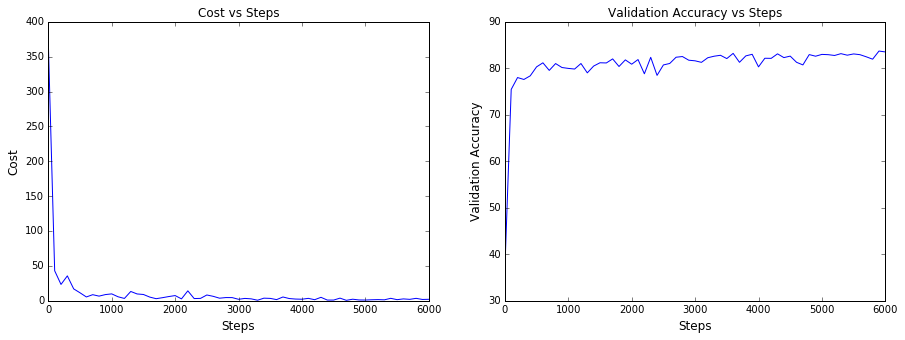

In [16]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5));
axes[0].plot(step_list, cost_list);
axes[0].set_title('Cost vs Steps');
axes[0].set_xlabel('Steps', size = 12);
axes[0].set_ylabel('Cost', size = 12);
axes[1].plot(step_list, V_accur_list);
axes[1].set_title('Validation Accuracy vs Steps');
axes[1].set_xlabel('Steps', size = 12);
axes[1].set_ylabel('Validation Accuracy', size = 12);